In [1]:
!pip install gudhi
!pip install giotto-tda
!pip install ripser

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

from sklearn.datasets import make_circles

# gudhi
import gudhi as gd
from gudhi import bottleneck_distance
from gudhi.hera import wasserstein_distance
from gudhi.representations import BettiCurve, PersistenceImage, Landscape

# giotto
import gtda
from gtda.homology import VietorisRipsPersistence
# from gtda.diagrams import BettiCurve, PersistenceImage, PersistenceLandscape

# ripser
from ripser import lower_star_img
from ripser import Rips

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

import torch
from torch.nn import Linear
from torch.nn.functional import relu

from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from tqdm import tqdm

np.set_printoptions(precision=2, suppress=True, linewidth=120)

In [3]:
def gudhi_toarray(diagrams):
    return np.array([[birth, death, dim] for (dim, (birth, death)) in diagrams])

In [4]:
def diagram_reshape(diagram):
    zero_idx = np.where(diagram[:,2]==0)
    one_idx = np.where(diagram[:,2]==1)
    return diagram[zero_idx], diagram[one_idx]

## Persistence diagrams

Topology studies data invariant to continous transformations, so topological invariants like (persistent) homology will not change under such class of transformations.

**Exercise**

Apply rotation and dilation transformations to copy of original data.

In [5]:
X, y = make_circles(n_samples=75*2, noise=0.1, random_state=0)
X = X[y==0]

In [6]:
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
print(R)

[[ 0.87 -0.5 ]
 [ 0.5   0.87]]


In [7]:
# transformed data
X_transformed = np.copy(X)
X_transformed[:,0] = X[:,0] * 2/3
X_transformed = np.dot(X_transformed, R)

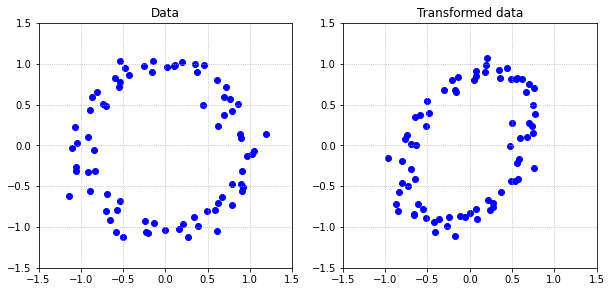

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4.5))

ax[0].set_title("Data")
ax[0].set_xlim(-1.5, 1.5)
ax[0].set_ylim(-1.5, 1.5)
ax[0].grid(linestyle="dotted")
ax[0].scatter(X[:,0], X[:,1], c="b")

ax[1].set_title("Transformed data")
ax[1].set_xlim(-1.5, 1.5)
ax[1].set_ylim(-1.5, 1.5)
ax[1].grid(linestyle="dotted")
ax[1].scatter(X_transformed[:,0], X_transformed[:,1], c="b")

plt.show()

### Persistent diagram

Compute persistence diagrams of the the Vietoris-Rips filtration of point cloud data

#### GUDHI

The GUDHI (Geometry Understanding in Higher Dimensions) library is a generic open source C++ library, with a Python interface for Topological Data Analysis. The library offers state-of-the-art data structures and algorithms to construct simplicial complexes and compute persistent homology.  
https://gudhi.inria.fr/python/latest/

In [9]:
vr_gudhi = gd.RipsComplex(points=X).create_simplex_tree(max_dimension=2)
diagram_gudhi = vr_gudhi.persistence()
diagram_gudhi # list of tuples (dim, (birth, death))

[(1, (0.2796067252546755, 1.4427652564206783)),
 (1, (0.20636150320943694, 0.24605980096209074)),
 (1, (0.26007353808196676, 0.29896960214003454)),
 (1, (0.25562423316501487, 0.26813275391427643)),
 (1, (0.17528728232727564, 0.1803547455857245)),
 (1, (0.14328883438842108, 0.144411508924264)),
 (1, (0.2060979805851268, 0.2071951212159325)),
 (0, (0.0, inf)),
 (0, (0.0, 0.2762693313527038)),
 (0, (0.0, 0.27327703996577873)),
 (0, (0.0, 0.26951007556637385)),
 (0, (0.0, 0.2668732202127708)),
 (0, (0.0, 0.25503998491297997)),
 (0, (0.0, 0.2506912960694995)),
 (0, (0.0, 0.24343108269883937)),
 (0, (0.0, 0.2324389275565635)),
 (0, (0.0, 0.23005721592487566)),
 (0, (0.0, 0.22993123809697064)),
 (0, (0.0, 0.220962298242722)),
 (0, (0.0, 0.21438270436950846)),
 (0, (0.0, 0.21134931613308572)),
 (0, (0.0, 0.19568950411451658)),
 (0, (0.0, 0.19502851325776688)),
 (0, (0.0, 0.1885069912373935)),
 (0, (0.0, 0.1852397699771907)),
 (0, (0.0, 0.17418572852073608)),
 (0, (0.0, 0.17417525699592665)),
 


#### Giotto

giotto-tda: A Topological Data Analysis Toolkit for Machine Learning and Data Exploration  
Tauzin et al. _Journal of Machine Learning Research (2021)_  
https://giotto-ai.github.io/gtda-docs/

In [10]:
vr_giotto = gtda.homology.VietorisRipsPersistence(homology_dimensions=[0, 1])
diagram_giotto = vr_giotto.fit_transform(np.expand_dims(X, 0))
diagram_giotto.shape # np.array of birth, death, dim

(1, 81, 3)

#### A list of list of numpy arrays convention

In [11]:
diagram_reshape(gudhi_toarray(diagram_gudhi))

(array([[0.  ,  inf, 0.  ],
        [0.  , 0.28, 0.  ],
        [0.  , 0.27, 0.  ],
        [0.  , 0.27, 0.  ],
        [0.  , 0.27, 0.  ],
        [0.  , 0.26, 0.  ],
        [0.  , 0.25, 0.  ],
        [0.  , 0.24, 0.  ],
        [0.  , 0.23, 0.  ],
        [0.  , 0.23, 0.  ],
        [0.  , 0.23, 0.  ],
        [0.  , 0.22, 0.  ],
        [0.  , 0.21, 0.  ],
        [0.  , 0.21, 0.  ],
        [0.  , 0.2 , 0.  ],
        [0.  , 0.2 , 0.  ],
        [0.  , 0.19, 0.  ],
        [0.  , 0.19, 0.  ],
        [0.  , 0.17, 0.  ],
        [0.  , 0.17, 0.  ],
        [0.  , 0.17, 0.  ],
        [0.  , 0.17, 0.  ],
        [0.  , 0.16, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.15, 0.  ],
        [0.  , 0.14, 0.  ],
        [0.  , 0.14, 0.  ],
        [0.  , 0.14,

In [12]:
diagram_reshape(diagram_giotto[0])

(array([[0.  , 0.02, 0.  ],
        [0.  , 0.02, 0.  ],
        [0.  , 0.04, 0.  ],
        [0.  , 0.05, 0.  ],
        [0.  , 0.05, 0.  ],
        [0.  , 0.05, 0.  ],
        [0.  , 0.05, 0.  ],
        [0.  , 0.06, 0.  ],
        [0.  , 0.06, 0.  ],
        [0.  , 0.06, 0.  ],
        [0.  , 0.07, 0.  ],
        [0.  , 0.08, 0.  ],
        [0.  , 0.08, 0.  ],
        [0.  , 0.08, 0.  ],
        [0.  , 0.08, 0.  ],
        [0.  , 0.08, 0.  ],
        [0.  , 0.09, 0.  ],
        [0.  , 0.09, 0.  ],
        [0.  , 0.09, 0.  ],
        [0.  , 0.09, 0.  ],
        [0.  , 0.09, 0.  ],
        [0.  , 0.09, 0.  ],
        [0.  , 0.1 , 0.  ],
        [0.  , 0.1 , 0.  ],
        [0.  , 0.11, 0.  ],
        [0.  , 0.11, 0.  ],
        [0.  , 0.11, 0.  ],
        [0.  , 0.11, 0.  ],
        [0.  , 0.11, 0.  ],
        [0.  , 0.11, 0.  ],
        [0.  , 0.12, 0.  ],
        [0.  , 0.12, 0.  ],
        [0.  , 0.12, 0.  ],
        [0.  , 0.12, 0.  ],
        [0.  , 0.12, 0.  ],
        [0.  , 0.12,

#### Persistence diagram of data and its transformation

In [13]:
X_vr = gd.RipsComplex(points=X).create_simplex_tree(max_dimension=2)
X_transformed_vr = gd.RipsComplex(points=X_transformed).create_simplex_tree(max_dimension=2)

X_diagram = diagram_reshape(gudhi_toarray(X_vr.persistence()))
X_transformed_diagram = diagram_reshape(gudhi_toarray(X_transformed_vr.persistence()))

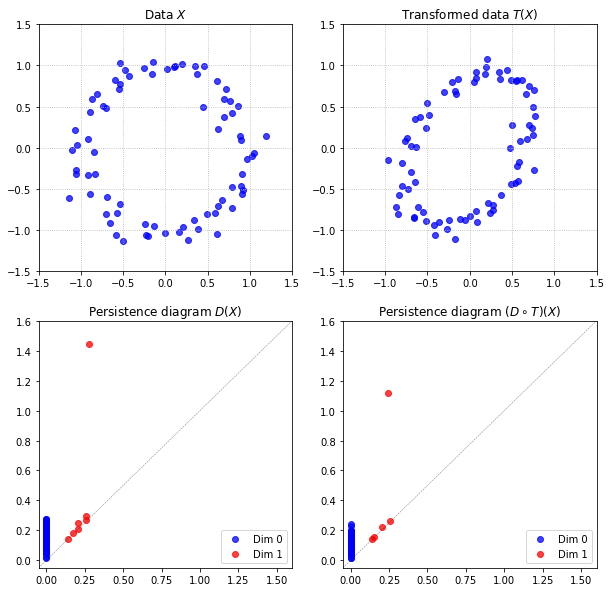

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

ax[0,0].set_title("Data $X$")
ax[0,0].set_xlim(-1.5, 1.5)
ax[0,0].set_ylim(-1.5, 1.5)
ax[0,0].grid(linestyle="dotted")
ax[0,0].scatter(X[:,0], X[:,1], c="b", alpha=0.75)

ax[0,1].set_title("Transformed data $T(X)$")
ax[0,1].set_xlim(-1.5, 1.5)
ax[0,1].set_ylim(-1.5, 1.5)
ax[0,1].grid(linestyle="dotted")
ax[0,1].scatter(X_transformed[:,0], X_transformed[:,1], c="b", alpha=0.75)

ax[1,0].set_title("Persistence diagram $D(X)$")
ax[1,0].set_xlim(-0.05, 1.6)
ax[1,0].set_ylim(-0.05, 1.6)
ax[1,0].scatter(X_diagram[0][:,0], X_diagram[0][:,1], c="b", alpha=0.75, label="Dim 0")
ax[1,0].scatter(X_diagram[1][:,0], X_diagram[1][:,1], c="r", alpha=0.75, label="Dim 1")
ax[1,0].legend(loc="lower right")
ax[1,0].plot([-0.05, 1.6], [-0.05, 1.6], c="k", linestyle="dashed", linewidth=0.5, alpha=0.5)

ax[1,1].set_title("Persistence diagram $(D \circ T)(X)$")
ax[1,1].set_xlim(-0.05, 1.6)
ax[1,1].set_ylim(-0.05, 1.6)
ax[1,1].scatter(X_transformed_diagram[0][:,0], X_transformed_diagram[0][:,1], c="b", alpha=0.75, label="Dim 0")
ax[1,1].scatter(X_transformed_diagram[1][:,0], X_transformed_diagram[1][:,1], c="r", alpha=0.75, label="Dim 1")
ax[1,1].legend(loc="lower right")
ax[1,1].plot([-0.05, 1.6], [-0.05, 1.6], c="k", linestyle="dashed", linewidth=0.5, alpha=0.5)

plt.show()

### Distances between persistence diagrams

One can define the geometry on the space of persistent diagrams. Distances between persistence diagrams can be computed using the optimal transport approach, with $p$-Wasserstein distance as the metric. The _bollteneck distance_ is the $\infty$-Wasserstein distance.

#### Bottleneck distance

In [15]:
bottleneck_dim0 = bottleneck_distance(X_diagram[0][:,:2], X_transformed_diagram[0][:,:2])
bottleneck_dim1 = bottleneck_distance(X_diagram[1][:,:2], X_transformed_diagram[1][:,:2])
bottleneck_dim0, bottleneck_dim1

(0.07305153252232394, 0.32639665385010463)

#### p-Wasserstein distance, $p=2$

In [16]:
wasserstein_dim0 = wasserstein_distance(X_diagram[0][:,:2], X_transformed_diagram[0][:,:2], order=2)
wasserstein_dim1 = wasserstein_distance(X_diagram[1][:,:2], X_transformed_diagram[1][:,:2], order=2)
wasserstein_dim0, wasserstein_dim1

(0.2609964598902254, 0.32773642511215545)

### Bottleneck distance stability

The Bottleneck distance stability to small perturbations is theoretically proved. Let's show its empirically.

In [17]:
n_samples = 75*2

n_noise_levels = 11
n_repeats = 10

# original data
X, y = make_circles(n_samples=n_samples, noise=0.0)

# original diagram
X_vr = gd.RipsComplex(points=X).create_simplex_tree(max_dimension=2)
X_diagram = diagram_reshape(gudhi_toarray(X_vr.persistence()))

distances = np.zeros((n_noise_levels, n_repeats))
X_noisy = np.zeros((n_noise_levels, n_samples, 2))

for j in tqdm(range(n_repeats)):
    for i, noise_level in enumerate(np.linspace(0, 0.3, n_noise_levels)):
        
        # i-th noisy data
        X_noise, _ = make_circles(n_samples=n_samples, noise=noise_level, random_state=j)
        X_noisy[i] = X_noise

        # i-th noisy diagram
        X_noise_vr = gd.RipsComplex(points=X_noise).create_simplex_tree(max_dimension=2)
        X_diagram_noise = diagram_reshape(gudhi_toarray(X_noise_vr.persistence()))
        
        # bottleneck distance
        bottleneck_dim0 = bottleneck_distance(X_diagram[0][:,:2], X_diagram_noise[0][:,:2])
        bottleneck_dim1 = bottleneck_distance(X_diagram[1][:,:2], X_diagram_noise[1][:,:2])
        distances[i,j] = 0.5 * bottleneck_dim0 + 0.5 * bottleneck_dim1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


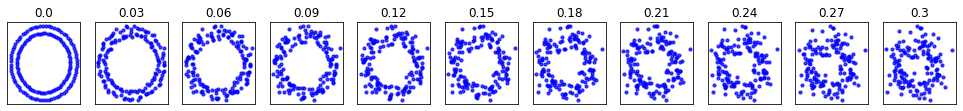

In [51]:
fig, ax = plt.subplots(ncols=11, figsize=(17,1.5))

for j in range(n_noise_levels):
    ax[j].set_title("{}".format(np.linspace(0, 0.3, n_noise_levels)[j]))
    ax[j].scatter(X_noisy[j,:,0], X_noisy[j,:,1], s=10, c="b", alpha=0.75)
    ax[j].set_xticks([])
    ax[j].set_yticks([])

plt.show()

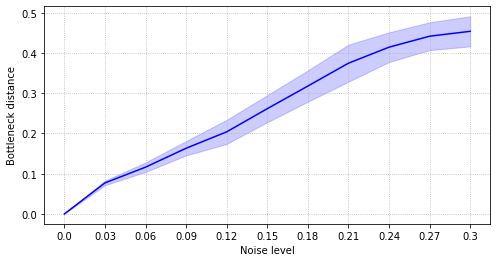

In [19]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlabel("Noise level")
ax.set_ylabel("Bottleneck distance")
ax.set_xticks(range(n_noise_levels), np.linspace(0, 0.3, n_noise_levels))
ax.grid(linestyle="dotted")
ax.plot(distances.mean(axis=1), c="b")

std = distances.std(axis=1)
lower = distances.mean(axis=1) - std
upper = distances.mean(axis=1) + std
ax.fill_between(range(n_noise_levels), lower, upper, color='b', alpha=.2)

plt.show()

## Vectorizations of persistence diagrams

#### Model data

Persistence Diagrams with Linear Machine Learning Models  
Obayashi et al. _Journal of Applied and Computational Topology (2018)_  
https://arxiv.org/abs/1706.10082

In [20]:
W = 300
sigma1 = 4
sigma2 = 2
t = 0.01

def generate(N, S, W=300, sigma1=4, sigma2=2, t=0.01, bins=64):

    z = np.zeros((N, S, 2))
    for n in range(N):
        z[n, 0] = np.random.uniform(0, W, size=(2))
        for s in range(S-1):
            d_1 = np.random.normal(0, sigma1)
            d_2 = np.random.normal(0, sigma1)
            z[n, s+1, 0] = (z[n, s, 0] + d_1) % W
            z[n, s+1, 1] = (z[n, s, 1] + d_2) % W

    z_r = z.reshape(N*S, 2)
    H, _, _ = np.histogram2d(z_r[:,0], z_r[:,1], bins=bins)
    
    G = sp.ndimage.gaussian_filter(H, sigma2)
    G[G < t] = 0
    
    return G

#### Generate 100 images of model A and B

In [21]:
images = np.zeros((100,64,64))
y = np.concatenate((np.zeros(50), np.ones(50)), axis=0)

# class A
N = 150
S = 20

for n in range(50):
    images[n] = generate(N, S)
    
# class B
N = 250
S = 10

for n in range(50):
    images[n+50] = generate(N, S)

#### Compute persistence diagrams

In [22]:
diags = []

for i in range(images.shape[0]):
    diags.append(lower_star_img(images[i])[:-1])

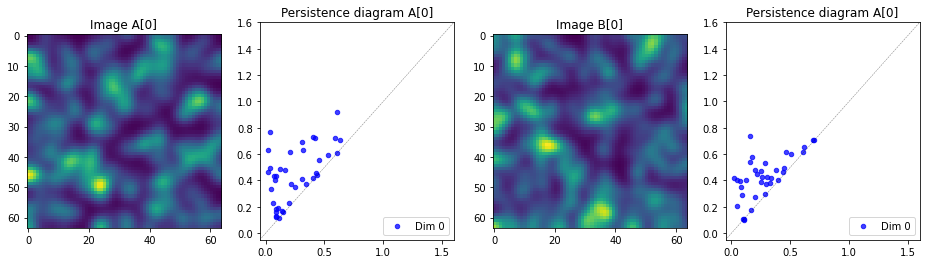

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))

ax[0].set_title("Image A[0]")
ax[0].imshow(images[0])

ax[1].set_title("Persistence diagram A[0]")
ax[1].set_xlim(-0.05, 1.6)
ax[1].set_ylim(-0.05, 1.6)
ax[1].scatter(diags[0][:,0], diags[0][:,1], s=20, c="b", alpha=0.75, label="Dim 0")
ax[1].legend(loc="lower right")
ax[1].plot([-0.05, 1.6], [-0.05, 1.6], c="k", linestyle="dashed", linewidth=0.5, alpha=0.5)

ax[2].set_title("Image B[0]")
ax[2].imshow(images[50])

ax[3].set_title("Persistence diagram A[0]")
ax[3].set_xlim(-0.05, 1.6)
ax[3].set_ylim(-0.05, 1.6)
ax[3].scatter(diags[50][:,0], diags[50][:,1], s=20, c="b", alpha=0.75, label="Dim 0")
ax[3].legend(loc="lower right")
ax[3].plot([-0.05, 1.6], [-0.05, 1.6], c="k", linestyle="dashed", linewidth=0.5, alpha=0.5)

plt.show()

## Vectorizations of persistence diagrams

#### Betti curve

In [24]:
bc = BettiCurve(resolution=8, predefined_grid=np.linspace(0, 2, 20))
betti_curve = bc.fit_transform([diags[0]])
betti_curve

array([[ 0, 13, 12, 15, 12,  8,  7,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

#### Persistence landscapes

In [25]:
pl = Landscape(num_landscapes=3, resolution=20)
persistence_landscapes = pl.fit_transform([diags[0]])
persistence_landscapes

array([[0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.46, 0.51, 0.45, 0.39, 0.33, 0.27, 0.21, 0.15, 0.14, 0.2 , 0.18,
        0.12, 0.06, 0.06, 0.12, 0.18, 0.24, 0.3 , 0.34, 0.4 , 0.38, 0.32, 0.26, 0.26, 0.22, 0.21, 0.15, 0.09, 0.09,
        0.03, 0.  , 0.  , 0.  , 0.04, 0.1 , 0.16, 0.22, 0.28, 0.31, 0.24, 0.22, 0.28, 0.24, 0.2 , 0.18, 0.21, 0.15,
        0.09, 0.03, 0.  , 0.  , 0.  , 0.  ]])

#### Persistence image

In [26]:
pi = PersistenceImage(bandwidth=0.1, resolution=[20, 20])
persistence_image = pi.fit_transform([diags[0]])
persistence_image

array([[ 84.73, 106.98, 123.8 , 132.07, 131.08, 122.78, 110.93,  99.54,  91.47,  87.68,  87.31,  88.45,  89.04,
         87.77,  84.34,  79.22,  73.  ,  65.96,  58.  ,  48.98,  98.09, 123.22, 142.08, 151.34, 150.34, 141.28,
        128.21, 115.36, 105.74, 100.41,  98.65,  98.66,  98.5 ,  96.87,  93.36,  88.27,  82.02,  74.69,  66.05,
         55.99, 102.12, 127.44, 146.27, 155.49, 154.59, 145.83, 133.04, 120.17, 109.96, 103.48, 100.24,  98.86,
         97.75,  95.79,  92.55,  88.1 ,  82.56,  75.8 ,  67.46,  57.4 ,  97.69, 120.83, 137.78, 145.92, 145.07,
        137.31, 125.97, 114.31, 104.59,  97.71,  93.44,  90.84,  88.81,  86.51,  83.58,  79.93,  75.45,  69.78,
         62.47,  53.35,  89.26, 109.05, 123.12, 129.51, 128.38, 121.65, 112.09, 102.25,  93.8 ,  87.39,  82.85,
         79.54,  76.77,  74.03,  71.09,  67.89,  64.21,  59.61,  53.57,  45.88,  82.43,  99.16, 110.43, 114.87,
        112.98, 106.68,  98.41,  90.22,  83.3 ,  77.94,  73.83,  70.36,  67.03,  63.59,  60.09,  56.63, 

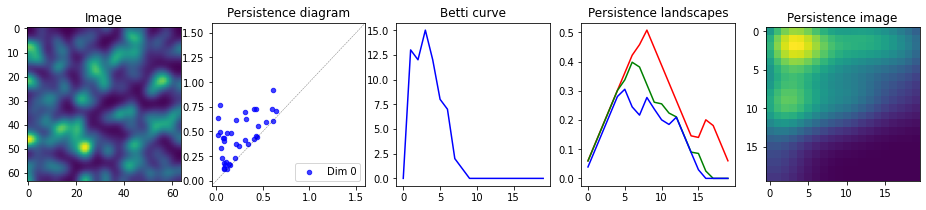

In [27]:
fig, ax = plt.subplots(ncols=5, figsize=(16, 3))

ax[0].set_title("Image")
ax[0].imshow(images[0])

ax[1].set_title("Persistence diagram")
ax[1].set_xlim(-0.05, 1.6)
ax[1].set_ylim(-0.05, 1.6)
ax[1].scatter(diags[0][:,0], diags[0][:,1], s=20, c="b", alpha=0.75, label="Dim 0")
ax[1].legend(loc="lower right")
ax[1].plot([-0.05, 1.6], [-0.05, 1.6], c="k", linestyle="dashed", linewidth=0.5, alpha=0.5)

ax[2].set_title("Betti curve")
ax[2].plot(betti_curve[0], c="b")

ax[3].set_title("Persistence landscapes")
ax[3].plot(persistence_landscapes[0][0:20], c="r")
ax[3].plot(persistence_landscapes[0][20:40], c="g")
ax[3].plot(persistence_landscapes[0][40:60], c="b")

ax[4].set_title("Persistence image")
ax[4].imshow(persistence_image[0].reshape(20, 20))

plt.show()

### Classification

#### Betti curves

In [28]:
bc = BettiCurve(resolution=50, predefined_grid=np.linspace(0, 4, 50))
X_betti_curves = bc.fit_transform(diags)
X_betti_curves.shape

(100, 50)

In [29]:
clf = RandomForestClassifier(random_state=0)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)

In [30]:
acc_curve_h0 = cross_val_score(clf, X_betti_curves, y, cv=cv)
print("Accuracy, Betti curve, H0: {:.4f} ± {:.4f}".format(np.mean(acc_curve_h0), np.std(acc_curve_h0)))

Accuracy, Betti curve, H0: 0.8680 ± 0.0662


### Embedding

In [31]:
X_pca = PCA().fit_transform(X_betti_curves)
X_isomap = Isomap().fit_transform(X_betti_curves)

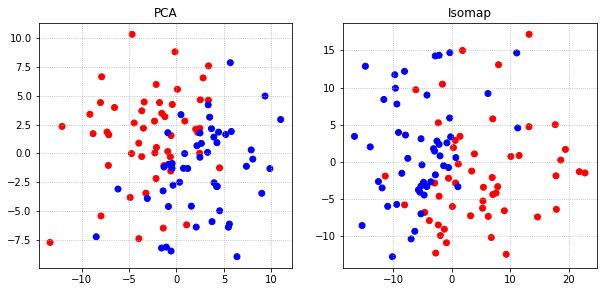

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4.5))
ax[0].set_title("PCA")
ax[0].grid(linestyle="dotted")
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y==0, cmap="bwr")
ax[1].set_title("Isomap")
ax[1].grid(linestyle="dotted")
ax[1].scatter(X_isomap[:, 0], X_isomap[:, 1], c=y==0, cmap="bwr")
plt.show()

## Learnable vectorizations of persistence diagrams

Persistence diagram is a multiset of vectors $D = \{(b_i, d_i, h_i)\}_{i=1}^N$ where $b_i$, $d_i$ are the birth and death times of $i$-th topological feature of dimension $h_i$. The classic approach to introduce persistent diagrams to machine learning is related to distances and kernels defined on the space of diagrams, which takes $O(n^2)$ time to compute. Vectrorization schemes such as persistence [images](https://arxiv.org/abs/1507.06217), [landscapes](https://arxiv.org/abs/1501.00179) or [curves](https://arxiv.org/abs/1904.07768) reduce the time to $O(n)$, yet all of this approaches are more or less fixed.

Trainable vectorization allows to learn vector representations of persistence diagrams, optimal w.r.t. the downstream task such as classification or regression. The simplest of such models, [Deep Sets](https://arxiv.org/abs/1703.06114) - $f: (\mathbb{R}^3)^N \rightarrow \mathbb{R}^d$

\begin{equation}
f(\{x_1, \dots, x_N\}) = \rho \left( \sum_{i=1}^N \phi(x_i) \right),
\end{equation}

consists of an encoder $\phi_\theta: \mathbb{R}^3 \rightarrow \mathbb{R}^D$ mapping each diagram point $x_i = (b_i, d_i, h_i)$, with parameters $\theta$ shared between points, a permutation invariant pooling operation $(\cdot): (\mathbb{R}^D)^N \rightarrow \mathbb{R}^D$ to obtain a representation of a diagram at whole (particulary for Deep Sets - sum pooling), and a decoder $\rho: \mathbb{R}^D \rightarrow \mathbb{R}^d$ which further transforms the diagram representation. It was [shown](https://arxiv.org/abs/1904.09378) that certain combinations of encoder/pooling/decoder correspond to the fixed representation schemes of persistence diagrams.

Deep sets encoder vectorizes each single point independently and does not consider the interdependence between points in the diagram. Thus, the self-attention block from the Transformer model which allows to capture those dependencies is a natural plug-in replacement to the encoder $\phi$.

\begin{equation}
\Phi_{ATTN}(\{x_1, \dots, x_N\}) = \left(\frac{(\mathbf{W}_q \mathbf{X})(\mathbf{W}_k \mathbf{X})^T}{\sqrt{D}} \right)\mathbf{W}_v\mathbf{X},
\end{equation}

where $\Phi_{ATTN}: (\mathbb{R}^3)^N \rightarrow (\mathbb{R}^D)^N$.

In [33]:
def generate_orbit(point_0, r, n=300):
    
    X = np.zeros([n, 2])
    
    xcur, ycur = point_0[0], point_0[1]
    
    for idx in range(n):
        xcur = (xcur + r * ycur * (1. - ycur)) % 1
        ycur = (ycur + r * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]
    
    return X

def generate_orbits(m, rs=[2.5, 3.5, 4.0, 4.1, 4.3], n=300, random_state=None):
    
    # m orbits, each of n points of dimension 2
    orbits = np.zeros((m * len(rs), n, 2))
    
    # for each r
    for j, r in enumerate(rs):

        # initial points
        points_0 = random_state.uniform(size=(m,2))

        for i, point_0 in enumerate(points_0):
            orbits[j*m + i] = generate_orbit(points_0[i], rs[j])
            
    return orbits

In [34]:
random_state = np.random.RandomState(42)
X_orbit5k = generate_orbits(1000, random_state=random_state)

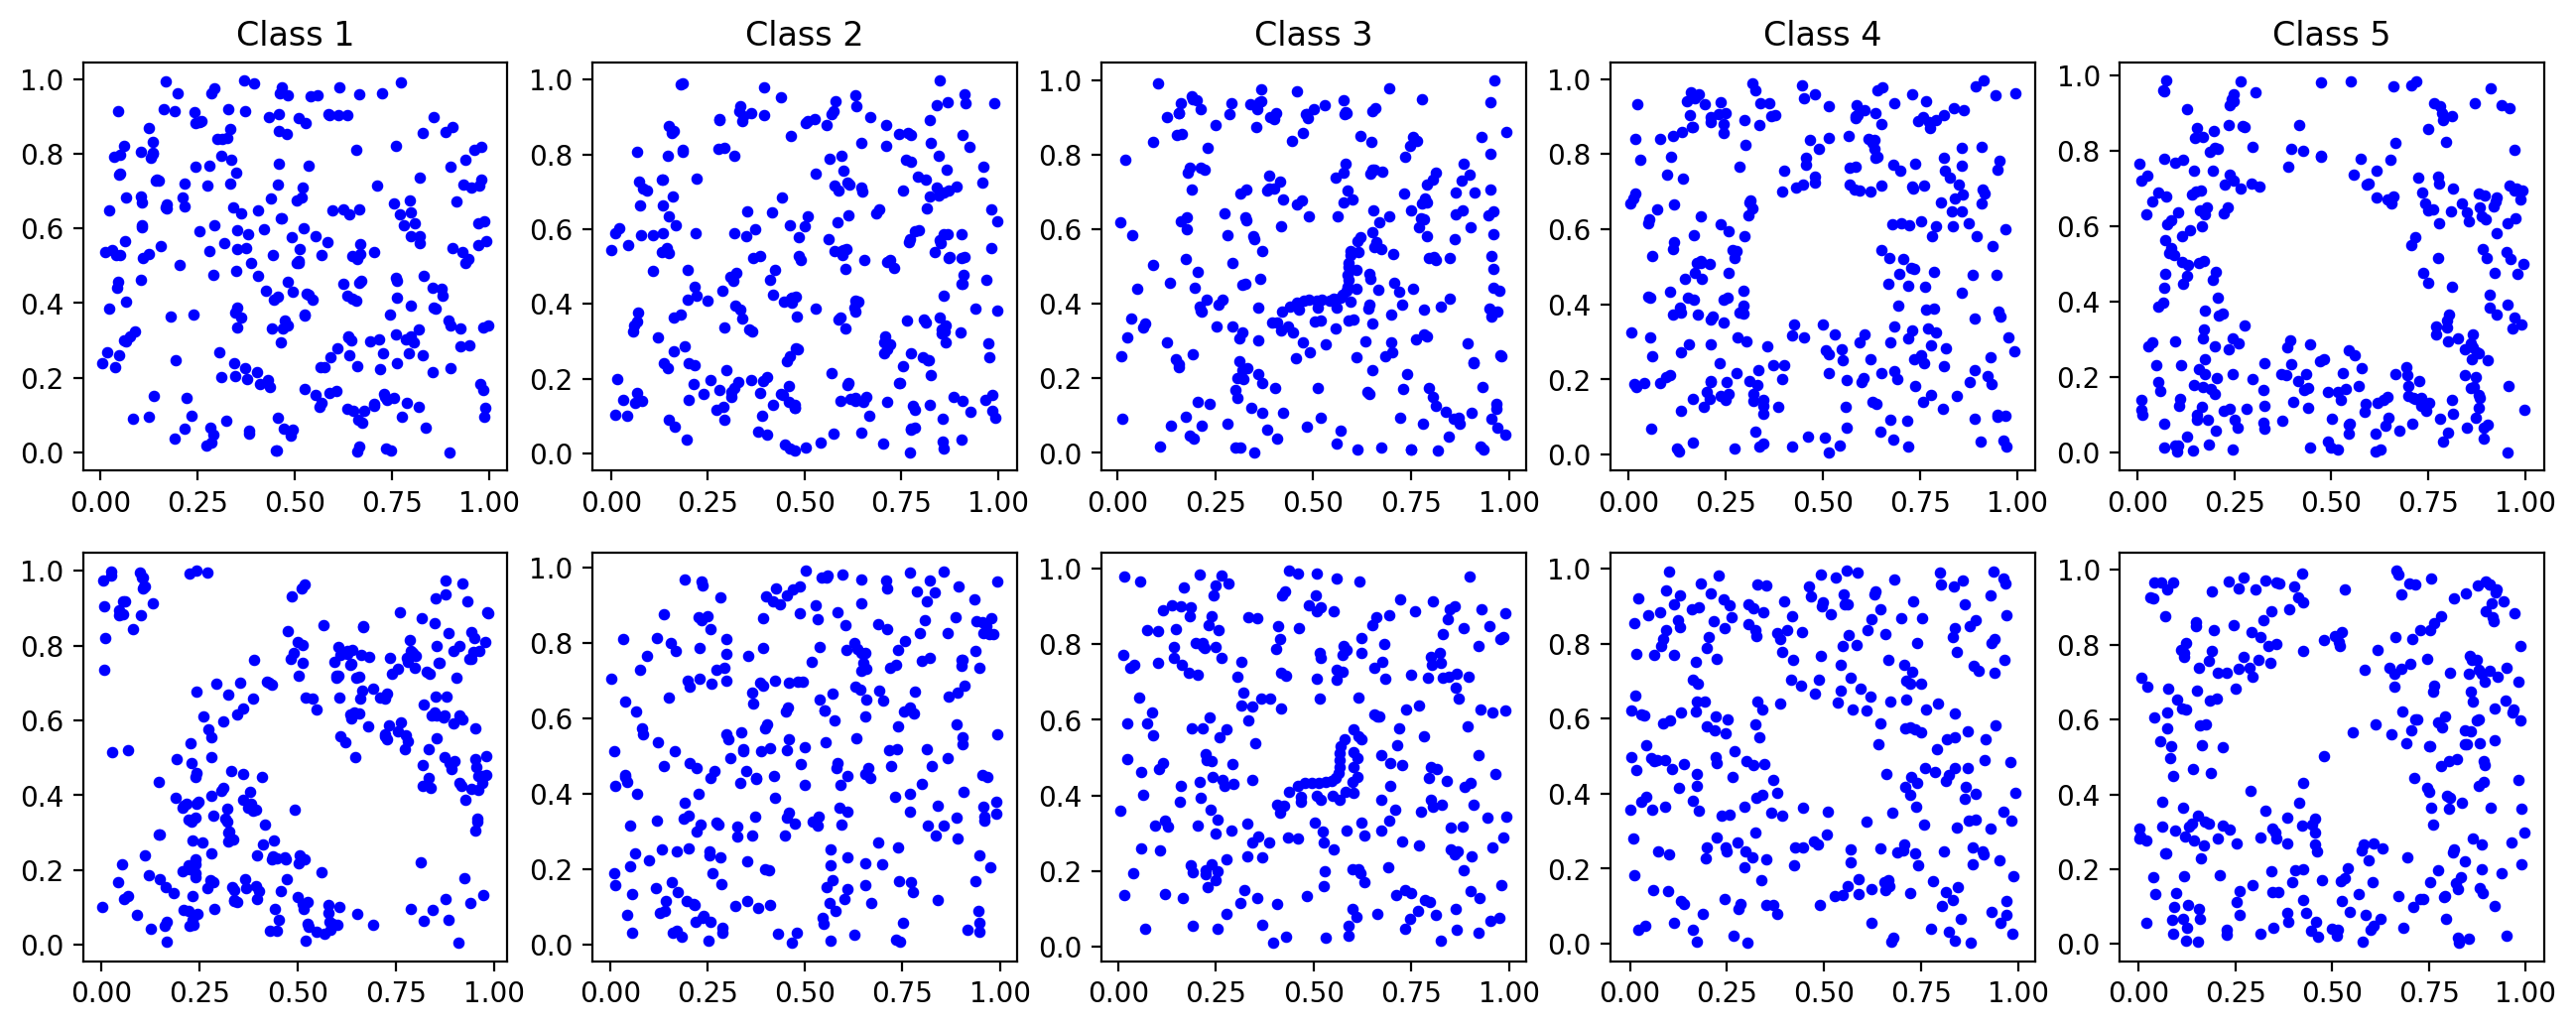

In [35]:
fig, ax = plt.subplots(2, 5, figsize=(16, 6), dpi=200)
for i in range(2):
    for j in range(5):
        if i==0:
            ax[i,j].set_title("Class {}".format(j+1))
        ax[i,j].scatter(X_orbit5k[j*1000+i,:,0], X_orbit5k[j*1000+i,:,1], s=10, c="b")

In [36]:
X_pc = np.concatenate((X_orbit5k[2000:3000], X_orbit5k[4000:5000]))
y = np.concatenate((np.zeros(1000), np.ones(1000)))

In [37]:
def conv_pd(diagrams):
    pd = np.zeros((0, 3))

    for k, diagram_k in enumerate(diagrams):
        diagram_k = diagram_k[~np.isinf(diagram_k).any(axis=1)] # filter infs  
        diagram_k = np.concatenate((diagram_k, k * np.ones((diagram_k.shape[0], 1))), axis=1)
        pd = np.concatenate((pd, diagram_k))

    return pd

In [38]:
X = []
vr = Rips()

for x_pc in tqdm(X_pc):
    diagram = conv_pd(vr.fit_transform(x_pc))
    X.append(diagram)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 47.06it/s]


#### Dataset

In [39]:
class Orbit2kDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def collate_fn(data):
    
    tmp_pd, _ = data[0]
    
    n_batch = len(data)
    n_features_pd = tmp_pd.shape[1]
    n_points_pd = max(len(pd) for pd, _ in data)
    inputs_pd = np.zeros((n_batch, n_points_pd, n_features_pd), dtype=float)
    labels = np.zeros(len(data))
    
    for i, (pd, label) in enumerate(data):
        inputs_pd[i][:len(pd)] = pd
        labels[i] = label
    
    return torch.Tensor(inputs_pd), torch.Tensor(labels).long()

#### Model

In [40]:
class DeepSets(torch.nn.Module):
    def __init__(self, n_in, n_hidden_enc, n_out_enc, n_hidden_dec=16, n_out_dec=2):
        super(DeepSets, self).__init__()
        self.encoder = Encoder(n_in, n_hidden_enc, n_out_enc)
        self.decoder = MLP(n_out_enc, n_hidden_dec, n_out_dec)
        
    def forward(self, X):
        z_enc = self.encoder(X)
        z = self.decoder(z_enc)
        return z
    
class MLP(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(MLP, self).__init__()
        self.linear1 = Linear(n_in, n_hidden)
        self.linear2 = Linear(n_hidden, n_out)
        
    def forward(self, X):
        X = relu(self.linear1(X))
        X = self.linear2(X)
        return X
    
class Encoder(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(Encoder, self).__init__()
        self.mlp = MLP(n_in, n_hidden, n_out)
        
    def forward(self, X):
        X = self.mlp(X)
        x = X.mean(dim=1) # aggregation
        return x

#### Train

In [41]:
%%time
n_repeats = 2
n_epochs = 100
batch_size = 16
lr = 0.001

n_train, n_test = 1600, 400

history = np.zeros((n_repeats, n_epochs, 3))
criterion = CrossEntropyLoss()

dataset = Orbit2kDataset(X, y)

for repeat_idx in range(n_repeats):
    
    # data init
    dataset_train, dataset_test = random_split(dataset, [n_train, n_test])
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test =  DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    
    # model init
    model = DeepSets(n_in=3, n_hidden_enc=16, n_out_enc=8)
    optimizer = Adam(model.parameters(), lr=lr)
    
    print("{:3} {:6} {:6} {:6}".format(repeat_idx, "Loss", "Train", "Test"))
    
    for epoch_idx in range(n_epochs):
        
        # train
        model.train()
        
        loss_epoch = []
        for batch in dataloader_train:
            loss_batch = criterion(model(batch[0]), batch[1])
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_epoch.append(loss_batch.detach())
        
        loss_epoch_mean = np.array(loss_epoch).mean()
        history[repeat_idx,epoch_idx,0] = loss_epoch_mean
        
        # test
        model.eval()
        
        correct = 0
        for batch in dataloader_train:
            y_hat = model(batch[0]).argmax(dim=1)
            correct += int((y_hat == batch[1]).sum())
        accuracy_train = correct / len(dataloader_train.dataset)
        history[repeat_idx,epoch_idx,1] = accuracy_train

        correct = 0
        for batch in dataloader_test:
            y_hat = model(batch[0]).argmax(dim=1)
            correct += int((y_hat == batch[1]).sum())
        accuracy_test = correct / len(dataloader_test.dataset)
        history[repeat_idx,epoch_idx,2] = accuracy_test
        
        print("{:3} {:.4f} {:.4f} {:.4f}".format(epoch_idx, loss_epoch_mean, accuracy_train, accuracy_test))
    print("\r")

  0 Loss   Train  Test  
  0 0.6945 0.4988 0.5050
  1 0.6937 0.4988 0.5050
  2 0.6930 0.5250 0.5275
  3 0.6931 0.5250 0.5300
  4 0.6922 0.5050 0.4975
  5 0.6912 0.6312 0.5950
  6 0.6896 0.6531 0.6350
  7 0.6856 0.6094 0.5700
  8 0.6792 0.6606 0.6325
  9 0.6682 0.5981 0.5825
 10 0.6567 0.6581 0.6225
 11 0.6458 0.5863 0.5825
 12 0.6327 0.6613 0.6250
 13 0.6238 0.6613 0.6400
 14 0.6189 0.6631 0.6325
 15 0.6170 0.6481 0.6300
 16 0.6097 0.6619 0.6425
 17 0.6055 0.6619 0.6425
 18 0.6076 0.6625 0.6325
 19 0.6077 0.6731 0.6350
 20 0.6043 0.6469 0.6175
 21 0.6056 0.6637 0.6350
 22 0.6027 0.6669 0.6275
 23 0.6038 0.6675 0.6175
 24 0.6010 0.6663 0.6500
 25 0.5998 0.6550 0.6275
 26 0.6022 0.6719 0.6325
 27 0.5999 0.6687 0.6475
 28 0.5968 0.6587 0.6550
 29 0.6007 0.6744 0.6350
 30 0.5951 0.6694 0.6375
 31 0.5967 0.6625 0.6250
 32 0.6011 0.6637 0.6425
 33 0.5950 0.6794 0.6375
 34 0.5975 0.6569 0.6475
 35 0.5956 0.6625 0.6500
 36 0.5943 0.6744 0.6425
 37 0.5936 0.6731 0.6450
 38 0.5923 0.6731 0.6400


In [42]:
x = np.arange(n_epochs)
loss_ci1 = history.mean(axis=0)[:,0] - history.std(axis=0)[:,0]
loss_ci2 = history.mean(axis=0)[:,0] + history.std(axis=0)[:,0]
acc_train_ci1 = history.mean(axis=0)[:,1] - history.std(axis=0)[:,1]
acc_train_ci2 = history.mean(axis=0)[:,1] + history.std(axis=0)[:,1]
acc_test_ci1 = history.mean(axis=0)[:,2] - history.std(axis=0)[:,2]
acc_test_ci2 = history.mean(axis=0)[:,2] + history.std(axis=0)[:,2]

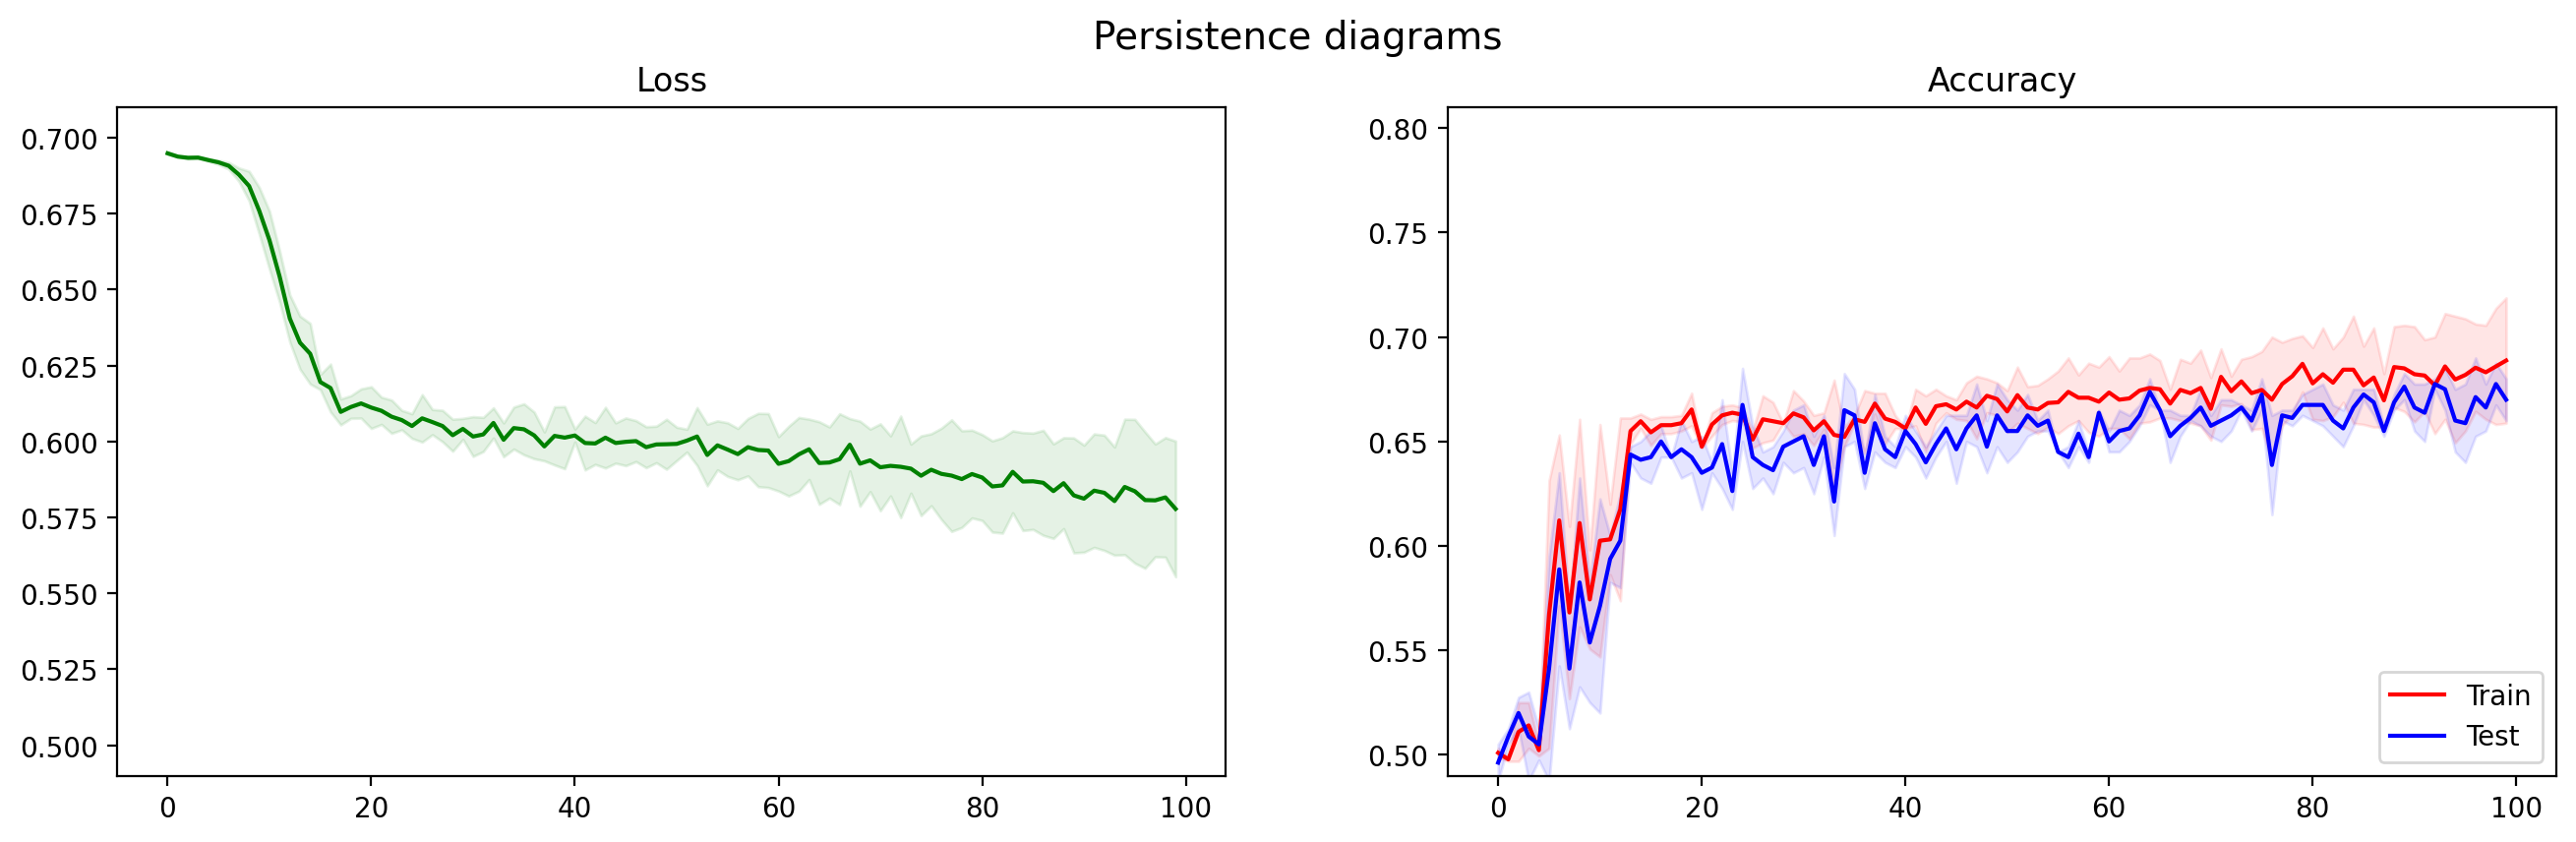

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
fig.suptitle("Persistence diagrams", fontsize=14)
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].set_ylim(0.49, 0.71)
ax[1].set_ylim(0.49, 0.81)
ax[0].plot(history.mean(axis=0)[:,0], c="g")
ax[0].fill_between(x, loss_ci1, loss_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:,1], c="r", label="Train")
ax[1].plot(history.mean(axis=0)[:,2], c="b", label="Test")
ax[1].fill_between(x, acc_train_ci1, acc_train_ci2, color="r", alpha=0.1)
ax[1].fill_between(x, acc_test_ci1, acc_test_ci2, color="b", alpha=0.1)
ax[1].legend(loc=4)
plt.show()